In [6]:
import pandas as pd
import plotly.express as px

paths = [
    '/Users/pb/Documents/Github/Tokemak/v2-rebalance-dashboard/mainnet_launch/database/schema/ensure_tables_are_current/using_3rd_party/autoUSD_primary_assets_quotes_slippage_3.5_bps_1_min_sleep.csv',
    '/Users/pb/Documents/Github/Tokemak/v2-rebalance-dashboard/mainnet_launch/database/schema/ensure_tables_are_current/using_3rd_party/autoUSD_primary_assets_quotes_slippage_3.5_bps.csv',
    "/Users/pb/Documents/Github/Tokemak/v2-rebalance-dashboard/15_min_auto_usd_combinations2.csv",
    "/Users/pb/Documents/Github/Tokemak/v2-rebalance-dashboard/15_min_auto_usd_combinations3.csv",
    "/Users/pb/Documents/Github/Tokemak/v2-rebalance-dashboard/15_min_auto_usd_combinations4.csv",
    "/Users/pb/Documents/Github/Tokemak/v2-rebalance-dashboard/15_min_auto_usd_combinations.csv"
]

dfs = [pd.read_csv(p) for p in paths]
df = pd.concat(dfs)
# df.to_csv("combined_swap_quotes.csv", index=True)
excluded = ['frxUSD']
df = df[(~df['sell_symbol'].isin(excluded)) & (~df['buy_symbol'].isin(excluded))].copy()
df['datetime_received'] = pd.to_datetime(df['datetime_received'])


In [7]:
px.scatter(df, x="datetime_received", y="label", title='Samples over time')

In [ ]:
df['long_label'] = df['label'] + ' ' + df['sell_amount_norm'].astype(int).astype(str)
df['15_min_chunk'] = df['datetime_received'].dt.floor('15min')

# I think we want 1 for each sample
df[['15_min_chunk', 'long_label']].value_counts().reset_index()['count'].value_counts()

count
1     6600
10      30
Name: count, dtype: int64

In [ ]:
df_unique = df[df.groupby(['15_min_chunk', 'long_label'])['long_label'].transform('count') == 1]
df_unique.columns

Index(['Unnamed: 0', 'buyAmount', 'minBuyAmount', 'aggregatorName',
       'datetime_received', '3rd_party_response_success', 'chainId',
       'systemName', 'slippageBps', 'taker', 'sellToken', 'buyToken',
       'sellAmount', 'includeSources', 'excludeSources', 'sellAll',
       'timeoutMS', 'method', 'url', 'buy_amount_norm', 'min_buy_amount_norm',
       'sell_amount_norm', 'buy_amount_price', 'min_buy_amount_price',
       'buy_symbol', 'sell_symbol', 'label', 'batch_id', 'long_label',
       '15_min_chunk'],
      dtype='object')

count
1     6600
10      30
Name: count, dtype: int64

In [11]:
px.violin(spreads)

NameError: name 'spreads' is not defined

In [ ]:
spread_df = df.groupby(["label", "sell_amount_norm"]).agg(
    buy_amount_price_min=("buy_amount_price", "min"),
    buy_amount_price_max=("buy_amount_price", "max"),
    min_buy_amount_price_min=("min_buy_amount_price", "min"),
    min_buy_amount_price_max=("min_buy_amount_price", "max"),
)
spread_df["buy_amount_spread_bps"] = 10_000 * (
    (spread_df["buy_amount_price_max"] - spread_df["buy_amount_price_min"]) / spread_df["buy_amount_price_min"]
)
spread_df["min_buy_amount_spread_bps"] = 10_000 * (
    (spread_df["min_buy_amount_price_max"] - spread_df["min_buy_amount_price_min"])
    / spread_df["min_buy_amount_price_min"]
)
spreads = (
    spread_df[["buy_amount_spread_bps", "min_buy_amount_spread_bps"]]
    .reset_index()
    .pivot(index="sell_amount_norm", columns="label", values="buy_amount_spread_bps")
)
px.violin(spreads)

In [ ]:
spreads

label,FRAX -> GHO,FRAX -> USDC,FRAX -> USDT,FRAX -> USDe,FRAX -> crvUSD,GHO -> FRAX,GHO -> USDC,GHO -> USDT,GHO -> USDe,GHO -> crvUSD,...,USDe -> FRAX,USDe -> GHO,USDe -> USDC,USDe -> USDT,USDe -> crvUSD,crvUSD -> FRAX,crvUSD -> GHO,crvUSD -> USDC,crvUSD -> USDT,crvUSD -> USDe
sell_amount_norm,,,,,,,,,,,,,,,,,,,,,
50000.0,5.690262,5.480539,6.950875,2.573895,6.095077,6.234538,2.161957,2.898780,5.638802,2.831959,...,2.016996,5.637190,6.985143,6.327069,10.904479,7.153648,2.362972,4.479933,2.323091,6.248891
100000.0,4.754706,5.920979,7.030762,3.804625,6.811891,5.221443,2.001999,3.579583,5.824133,2.150540,...,1.336898,6.078913,7.458756,6.891176,6.652116,6.970685,2.201838,2.549542,3.093923,7.467350
150000.0,5.416576,5.943224,5.846952,1.806197,6.121743,5.912756,1.613787,2.908217,5.518056,2.372600,...,1.237785,5.880373,6.265207,7.080884,6.634866,6.702223,2.514526,18.493489,2.562480,6.643272
200000.0,5.072473,5.445916,8.286567,1.735493,5.876000,4.617412,1.631794,2.837392,6.495430,1.977187,...,4.309889,6.004275,6.368017,6.289490,6.452393,6.519604,2.527946,2.659510,1.957768,6.204570
250000.0,4.919508,5.480801,6.050552,1.740067,5.949633,6.019428,1.518861,2.551052,6.817372,1.608445,...,1.243425,5.727222,5.917047,6.785970,6.720717,5.870458,2.182946,2.315997,2.628870,6.751585


In [ ]:
df["datetime_received"] = pd.to_datetime(df["datetime_received"])
df["datetime_received"].max() - df["datetime_received"].min()

Timedelta('0 days 22:39:36.686251')

In [ ]:
px.scatter(
    df,
    x="sell_amount_norm",
    y="buy_amount_price",
    color="label",
    size="min_buy_amount_price",
    hover_data=["datetime_received"],
)

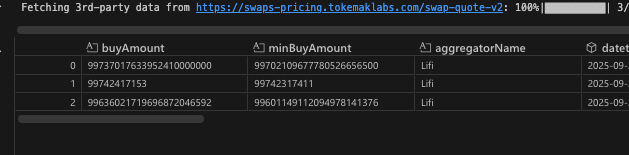

In [ ]:
df.columns

Index(['Unnamed: 0', 'buyAmount', 'minBuyAmount', 'aggregatorName',
       'datetime_received', '3rd_party_response_success', 'chainId',
       'systemName', 'slippageBps', 'taker', 'sellToken', 'buyToken',
       'sellAmount', 'includeSources', 'excludeSources', 'sellAll',
       'timeoutMS', 'method', 'url', 'buy_amount_norm', 'min_buy_amount_norm',
       'sell_amount_norm', 'buy_amount_price', 'min_buy_amount_price',
       'buy_symbol', 'sell_symbol', 'label', 'batch_id', 'long_label'],
      dtype='object')

In [ ]:
# I have a feeling that the swap matrix is optimizing for the wrong thing, min buy amount vs buy amount?